In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 

data = pd.read_csv("AAPL.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400
...,...,...,...,...,...,...,...
5996,2023-11-01,171.000000,174.229996,170.119995,173.970001,173.970001,56934900
5997,2023-11-02,175.520004,177.779999,175.460007,177.570007,177.570007,77334800
5998,2023-11-03,174.240005,176.820007,173.350006,176.649994,176.649994,79763700
5999,2023-11-06,176.380005,179.429993,176.210007,179.229996,179.229996,63841300


In [166]:
data = data[["Date", "Close"]]
data

,Date,Close
0,2000-01-03,0.999442
1,2000-01-04,0.915179
2,2000-01-05,0.928571
3,2000-01-06,0.848214
4,2000-01-07,0.888393
...,...,...
5996,2023-11-01,173.970001
5997,2023-11-02,177.570007
5998,2023-11-03,176.649994
5999,2023-11-06,179.229996


In [167]:
# this allows us to enable gpu if we have gpu
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

/var/folders/98/6x2vtmsd3mq4_ylswvznj38r0000gn/T/ipykernel_1444/1781244370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Date"] = pd.to_datetime(data["Date"])


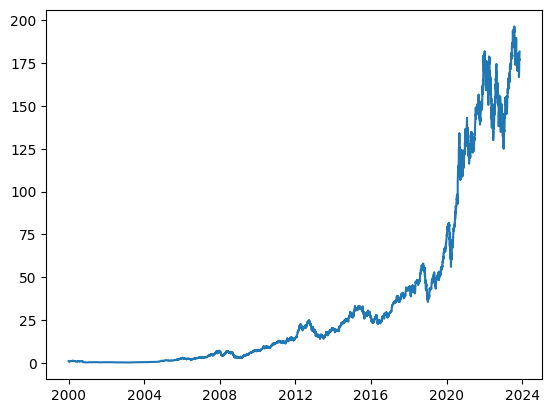

In [168]:
data["Date"] = pd.to_datetime(data["Date"])
plt.plot(data["Date"], data["Close"])

In [169]:
from copy import deepcopy as dc 

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index("Date", inplace=True)

    for i in range(1, n_steps+1):
        df[f"Close(t-{i})"] = df["Close"].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-01-12,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442
2000-01-13,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179
2000-01-14,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571
2000-01-18,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214
2000-01-19,0.951451,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393
...,...,...,...,...,...,...,...,...
2023-11-01,173.970001,170.770004,170.289993,168.220001,166.889999,171.100006,173.440002,173.000000
2023-11-02,177.570007,173.970001,170.770004,170.289993,168.220001,166.889999,171.100006,173.440002
2023-11-03,176.649994,177.570007,173.970001,170.770004,170.289993,168.220001,166.889999,171.100006


In [170]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[  0.77846003,   0.828125  ,   0.87276798, ...,   0.92857099,
          0.91517901,   0.99944198],
       [  0.86383897,   0.77846003,   0.828125  , ...,   0.84821397,
          0.92857099,   0.91517901],
       [  0.89676303,   0.86383897,   0.77846003, ...,   0.88839298,
          0.84821397,   0.92857099],
       ...,
       [176.6499939 , 177.57000732, 173.97000122, ..., 168.22000122,
        166.88999939, 171.1000061 ],
       [179.22999573, 176.6499939 , 177.57000732, ..., 170.28999329,
        168.22000122, 166.88999939],
       [181.82000732, 179.22999573, 176.6499939 , ..., 170.77000427,
        170.28999329, 168.22000122]])

In [171]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99445331, -0.99394708, -0.99349204, ..., -0.99292325,
        -0.99305975, -0.99220087],
       [-0.99358305, -0.99445331, -0.99394708, ..., -0.99374232,
        -0.99292325, -0.99305975],
       [-0.99324746, -0.99358305, -0.99445331, ..., -0.99333278,
        -0.99374232, -0.99292325],
       ...,
       [ 0.79818127,  0.80755884,  0.77086447, ...,  0.7122555 ,
         0.69869897,  0.741611  ],
       [ 0.82447887,  0.79818127,  0.80755884, ...,  0.73335465,
         0.7122555 ,  0.69869897],
       [ 0.85087851,  0.82447887,  0.79818127, ...,  0.73824733,
         0.73335465,  0.7122555 ]])

In [172]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5994, 7), (5994,))

In [173]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99220087, -0.99305975, -0.99292325, ..., -0.99333278,
        -0.99349204, -0.99394708],
       [-0.99305975, -0.99292325, -0.99374232, ..., -0.99349204,
        -0.99394708, -0.99445331],
       [-0.99292325, -0.99374232, -0.99333278, ..., -0.99394708,
        -0.99445331, -0.99358305],
       ...,
       [ 0.741611  ,  0.69869897,  0.7122555 , ...,  0.73824733,
         0.77086447,  0.80755884],
       [ 0.69869897,  0.7122555 ,  0.73335465, ...,  0.77086447,
         0.80755884,  0.79818127],
       [ 0.7122555 ,  0.73335465,  0.73824733, ...,  0.80755884,
         0.79818127,  0.82447887]])

In [174]:
split_index = int(len(X)*0.95)
split_index

5694

In [175]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5694, 7), (300, 7), (5694,), (300,))

In [176]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5694, 7, 1), (300, 7, 1), (5694, 1), (300, 1))

In [177]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5694, 7, 1]),
 torch.Size([300, 7, 1]),
 torch.Size([5694, 1]),
 torch.Size([300, 1]))

In [178]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [179]:
train_dataset

In [180]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [181]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [182]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out 
    
model = LSTM(1, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [183]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [184]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [185]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.527
Batch 200, Loss: 0.229
Batch 300, Loss: 0.150

Val Loss: 0.707
***************************************************

Epoch: 2
Batch 100, Loss: 0.034
Batch 200, Loss: 0.017
Batch 300, Loss: 0.012

Val Loss: 0.139
***************************************************

Epoch: 3
Batch 100, Loss: 0.007
Batch 200, Loss: 0.006
Batch 300, Loss: 0.003

Val Loss: 0.051
***************************************************

Epoch: 4
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.032
***************************************************

Epoch: 5
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.018
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.015
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.009
*****************

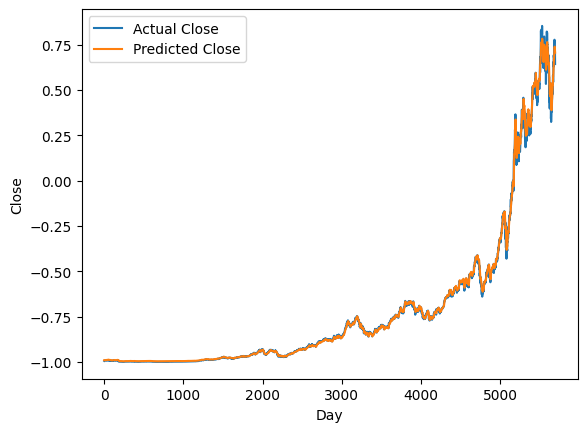

In [186]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [187]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  1.14865908,   1.12183576,   1.11574832, ..., 169.01390976,
       168.87933117, 167.60753009])

In [188]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([  0.77845976,   0.86384179,   0.89676425, ..., 170.02999746,
       163.61999446, 161.38000407])

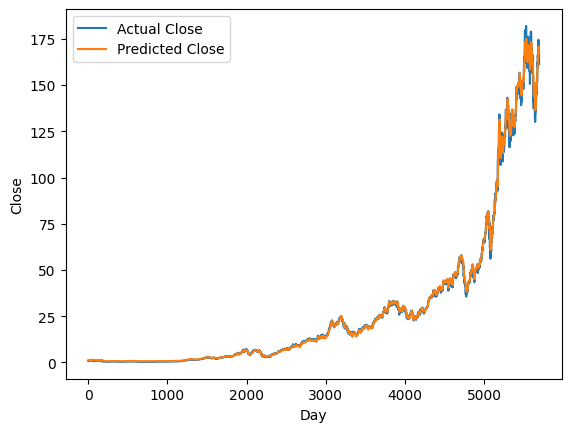

In [189]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [190]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([166.22158223, 164.77564883, 163.4476983 , 162.42504365,
       161.07226385, 159.52845192, 158.85042467, 158.10752321,
       158.17785916, 159.41623487, 158.62811327, 158.47197426,
       157.86723604, 156.95942405, 156.97747   , 157.16572449,
       156.33526566, 156.09117164, 155.37107031, 155.04741855,
       155.04330178, 154.36557861, 152.1518794 , 149.61806628,
       148.40835007, 148.20319578, 147.97725882, 147.49451497,
       146.14826119, 145.69846904, 145.3123991 , 144.48994575,
       144.47651362, 143.39062212, 143.45410458, 144.17198379,
       144.78600814, 145.33946218, 146.67336566, 147.91256004,
       149.88169157, 150.65005384, 150.33744835, 152.31892434,
       153.46897663, 153.65277518, 152.55910041, 150.21680479,
       148.35981429, 147.1052522 , 145.27977487, 142.81909874,
       143.51913667, 145.04785573, 146.51509809, 148.21150534,
       149.39563793, 150.82527384, 152.45101182, 152.29621193,
       152.43723468, 152.81221156, 152.4152123 , 151.38

In [191]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([158.91000087, 157.22000269, 157.96000954, 155.80999746,
       154.52999794, 155.96000809, 154.46000701, 157.36999578,
       163.42999152, 153.83999463, 155.3099971 , 152.36999801,
       150.6999989 , 154.47999439, 156.89999404, 153.72000016,
       152.74000436, 150.4299938 , 150.77000153, 151.75999686,
       149.83999758, 142.47999447, 138.1999957 , 142.44999585,
       146.1000061 , 146.39999521, 145.4299931 , 140.08999637,
       140.41999871, 138.97999486, 138.3399951 , 142.99000607,
       138.38000495, 142.41000354, 143.7500003 , 143.86000109,
       143.38999934, 147.27000484, 149.449998  , 152.33999354,
       149.35000845, 144.80000165, 155.74000653, 153.33999427,
       150.64999536, 145.02999983, 138.88000531, 138.38000495,
       138.91999762, 139.50000015, 134.86999411, 146.86999403,
       149.69999818, 148.27999926, 150.03999422, 148.78999331,
       150.72000383, 151.28999512, 148.00999415, 150.17999362,
       151.07000525, 148.11000124, 144.22000205, 141.16

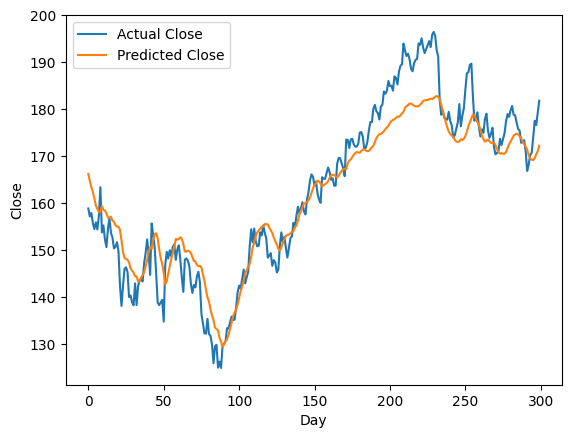

In [192]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()